## End to End pet-проект: прогноз дефолта по кредиту (Credit Risk Dataset)

### План работ
1. Данные: загрузка, проверка качества, разбиение train val test
2. Baseline: простая модель и базовые метрики
3. Пайплайн: единый препроцессинг и обучение без утечек
4. Улучшение модели, настройка и сравнение
5. Интерпретация: важность признаков и простые выводы
6. Артефакты: сохранение модели и препроцессинга
7. API: FastAPI
8. Хранилище: запись запросов и предсказаний в Postgres
9. Мини интерфейс: простая форма для ввода и ответа модели

Цель: собрать воспроизводимый пайплайн от данных до API и демонстрации результата.

### 1) Импорт библиотек и данных

In [81]:
import pandas as pd
import numpy as np
from typing import Optional, List
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

In [28]:
data = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "laotse/credit-risk-dataset",
    "credit_risk_dataset.csv"
)
data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


### Посмотрим на базовые данные про полученный data

In [29]:
size = data.shape
nans = data.isna().sum()

print(f'Размер: {size}; Колличество пропусков: {nans}')

Размер: (32581, 12); Колличество пропусков: person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [55]:
data.dtypes

person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
load_status                     int64
dtype: object

<Axes: ylabel='Frequency'>

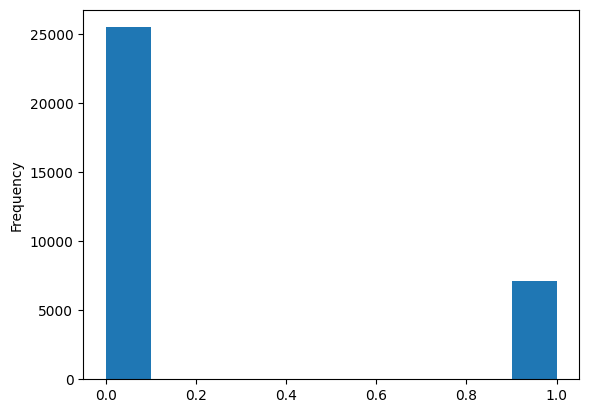

In [ ]:
data['loan_status'].plot(kind = 'hist')

### Таргет находится в колонке loan_status

- Соотношение доли обьектов положительно и отрицательного класса ~ 78 к 22 (присутсвует дисбаланс классов)

In [45]:
loan_zero_and_one = data['loan_status'].value_counts()
loan_percent = data['loan_status'].value_counts(normalize = True)
mean = data['loan_status'].mean()
print(
    f'Колличество таргетов 0/1: {loan_zero_and_one}; \
    Отношение колличества обьектов 0/1: {loan_percent}; \
    Итоговая доля дефолта: {mean}'
)

Колличество таргетов 0/1: loan_status
0    25473
1     7108
Name: count, dtype: int64;     Отношение колличества обьектов 0/1: loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64;     Итоговая доля дефолта: 0.21816396059052823


### Найдем долю пропусков в столбцах имеющих их(как с ними поступить решим далее)
1) person_emp_length 
2) loan_int_rate

In [63]:
person_emp = data['person_emp_length']
loan_rate = data['loan_int_rate']

diff_person = person_emp.isna().sum() / len(person_emp)
diff_rate = loan_rate.isna().sum() / len(loan_rate)

print(
    f'Доля пропусков в первом столбце: {diff_person}; \
    Доля пропусков в втором столбце: {diff_rate}'
)

Доля пропусков в первом столбце: 0.027469997851508547;     Доля пропусков в втором столбце: 0.0956385623522912


#### Разделим данные на выборки и проверим доли тергетов в выборках


In [76]:
test_size = 0.2
X_train, X_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop("loan_status")],
    np.array(data['loan_status']),
    test_size = test_size,
    random_state = 1,
    stratify = data['loan_status']
)

In [77]:
print(
    f'Доля таргетов в Train: {Y_train.mean()}; \
    Доля таргетов в Test: {Y_test.mean()}'
)

Доля таргетов в Train: 0.21815531000613875;     Доля таргетов в Test: 0.21819855761853613


## 2) Baseline

- Метрики: ROC-AUC и PR-AUC 
- Базовая модель: логистическая регрессия
- Оценка качества: Stratified K-Fold
- Препроцессинг в пайплайне: 
  - числовые признаки: заполнение пропусков медианой
  - категориальные признаки: one-hot кодирование
- Цель: получить точку отсчета

### Преобразование

- колонки с пропусками заменим медианой
- колонки с категорильными признаками заменим с помощью OHE

In [ ]:
object_cols = X_train.select_dtypes(include = 'object').columns.to_list()
num_cols = X_train.select_dtypes(include = ["float64", "int64"]).columns.to_list()


imputer = SimpleImputer(strategy = 'median')
ohe = OneHotEncoder(handle_unknown = 'ignore')

prepare = ColumnTransformer(
    transformers = [
        ('num_cols', imputer, num_cols),
        ('cat_cols', ohe, object_cols)
    ]
)

### Подсчет матрик

In [ ]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

model = LogisticRegression()

pipe_base = Pipeline(
    steps = [
        ('transform', prepare),
        ('model', model)
    ]
)

score = {
    'pr_auc': 'average_precision',
    'ROC-AUC':'roc_auc'
}

make_score = cross_validate(pipe_base, X_train, Y_train, cv = cv, scoring = score)



/Users/rodion/VsCodeProjects/Trening/trening/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rodion/VsCodeProjects/Trening/trening/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    h